## Comparison of diffraction methods

In this notebook: transform of circular apertured plane wave example by plotting analytical result, Fresnel diffraction, and Fourier propagation (angular spectrum decomposition, mathematically equivalent to Rayleigh-Sommerfeld but uses FFT).

## todo
* plot output field for high-NA lens transform of plane wave which should not be correctly predicted by Fresnel diffraction, but will be given by Fourier decomp.

In [1]:
## general imports
from numpy import *
from numpy.fft import fft,ifft,fft2,ifft2,fftshift,ifftshift
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from matplotlib import colors
from time import time
import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

In [3]:
## physics and system params. all units in m
lmbda = 1.064
k = 2*pi/lmbda
f = 1e5 # lens focal length
a = 100 # the aperture radius

## grid params
w = 2*a # grid half-width
pts = 1025
x0pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)
# print('rr.shape =', rr.shape)
mask = circ_mask(rr, a)
# mask.shape

In [20]:
## physics and system params. all units in m
lmbda = 1.064
k = 2*pi/lmbda
f = 1e5 # lens focal length
a = 100 # the aperture radius

## grid params
w = 2*a # grid half-width
pts = 5001
x0pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)
# print('rr.shape =', rr.shape)
mask = circ_mask(rr, a)
# mask.shape

In [32]:
2*a/pts

0.03999200159968006

In [36]:
x0pts[1]-x0pts[0]

0.0800000000000125

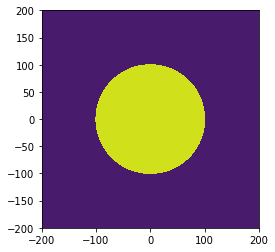

In [21]:
fig, ax = figax()
ax.contourf(x0pts, x0pts, mask)

In [5]:
## compute output field with Fresnel diffraction

padding = int(pts-1/2)
field0 = zero_pad(mask, padding)
rr = zero_pad(rr, padding)

field1 = fftshift(fft2(ifftshift(field0)))

field1 = unpad(field1, padding)
rr = unpad(rr, padding)

I1 = conjugate(field1)*field1
I1 /= amax(I1)
I1x = justify(I1[midpt,:])

In [22]:
## compute output field with Fourier propagation

field0 = zero_pad(mask, padding)
total_pts = len(field0[0])
xspan = (x0pts[1] - x0pts[0])*total_pts

# define k space grid and field
dfx = 1/(xspan)
fx_list = range(-(total_pts-1)//2,(total_pts-1)//2+1,1)*dfx
kx_list = 2*pi*fx_list
ky_list = -kx_list
KX, KY = meshgrid(kx_list, ky_list)
KZ_real = real(sqrt(k**2 - KX**2 - KY**2 + 0j))
KZ_imag = imag(sqrt(k**2 - KX**2 - KY**2 + 0j))
KZ = KZ_real + 1j*abs(KZ_imag)
field0_kspace = fftshift(fft2(field0))

# propagate
phase = f*KZ_real
field1_kspace = field0_kspace*exp(1j*f*KZ)

# transform back to real space
field1 = ifft2(field1_kspace)
print(field1.shape)
field1 = unpad(field1, padding)
I1_FD = real(conjugate(field1)*field1)
I1_FD /= amax(I1_FD)
I1x_FD = I1_FD[midpt,:]

(7049, 7049)


In [25]:
# check if the angular spectrum decomposition is valid:

N = total_pts
z = f
dx = x0pts[1] - x0pts[0]

condition = z/(2*N*dx**2*sqrt(1-(lmbda/(2*dx))**2)/lmbda)
assert condition < 1, condition

C:\Users\prest\AppData\Local\Temp/ipykernel_8776/1296611308.py:7: RuntimeWarning: invalid value encountered in sqrt
  condition = z/(2*N*dx**2*sqrt(1-(lmbda/(2*dx))**2)/lmbda)


AssertionError: nan

In [30]:
lmbda

1.064

In [18]:
field1 = ifftshift(ifft2(field1_kspace))
print(field1.shape)
field1 = unpad(field1, padding)
I1_FD = real(conjugate(field1)*field1)
I1_FD /= amax(I1_FD)
I1x_FD = I1_FD[midpt,:]

(5049, 5049)


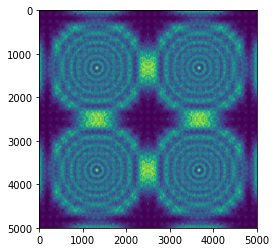

In [23]:
plt.imshow(I1_FD)

In [28]:
fft?

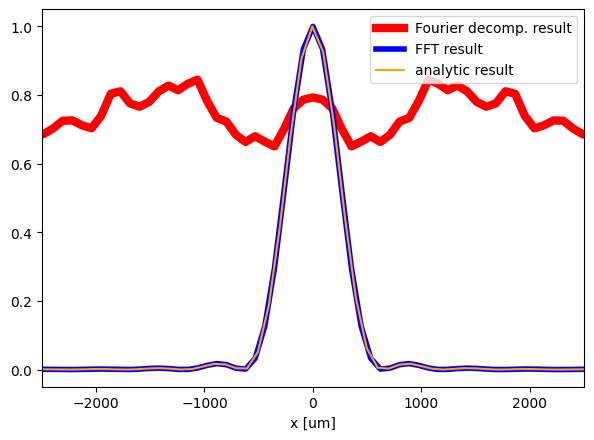

In [12]:
## plot a slice of the field in the Fourier plane

plt.close()
fig,ax = plt.subplots(figsize=(7,5))
fig.dpi=100

x1pts = array([i*1/(x0pts[1]-x0pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])

start = 400
stop = len(x1pts) - start

# plot the analytic result, up to constant scaling factor
I1_func = lambda x: (j1(a*x*k/f)/x)**2
x1_pts = linspace(x1pts[start],x1pts[stop],200) # essentially the same as x1pts but omits x=0
I1_analytic = I1_func(x1_pts)
I1_analytic /= max(I1_analytic)

# plot the fourier decomp result
ax.plot(x1pts[start:stop], real(I1x_FD)[start:stop], label='Fourier decomp. result',color='red',linewidth=6)

# plot the fft result
ax.plot(x1pts[start:stop], real(I1x)[start:stop], label='FFT result',color='blue',linewidth=4)

ax.plot(x1_pts, I1_analytic, label='analytic result', color='orange')
# ax.set_title('Circular apperture diffraction intensity')

ax.set_xlabel(r'x [um]')
ax.set_xlim(-2500,2500)

ax.legend(loc='upper right')

## Chengyu's example